<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp3_parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab import drive 
import nltk
import functools
import xgboost as xgb
import lightgbm as lgb

drive.mount('/content/gdrive')
path_a_training_set = 'gdrive/MyDrive/TP3 dataset music/train.parquet'
path_a_test_set = 'gdrive/MyDrive/TP3 dataset music/test.parquet'


df_music_train = pd.read_parquet(path_a_training_set).fillna("")
df_music_test = pd.read_parquet(path_a_test_set).fillna("")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

genres = list(df_music_train["genre"].unique())
def get_vectorizers_by_genre(df_music: pd.DataFrame) -> dict:
  df_music_lyric_tokenized = df_music.copy().fillna("")
  df_music_lyric_tokenized["lyric"] = df_music_lyric_tokenized["lyric"].map(lambda lyric: set(nltk.word_tokenize(lyric)))
  df_music_grouped_by_genre = df_music_lyric_tokenized[["genre", "lyric"]].groupby('genre').agg(lambda x: functools.reduce(set.union, x)).reset_index()
  vocabs = dict(zip(df_music_grouped_by_genre.genre.to_list(), df_music_grouped_by_genre.lyric.to_list()))
  stopwords = set(nltk.corpus.stopwords.words("english")).union(set(nltk.corpus.stopwords.words("spanish"))).union(set(nltk.corpus.stopwords.words("french")))
  vectorizers = {genre: TfidfVectorizer(input = "content", stop_words = stopwords, vocabulary = vocabs[genre]) for genre in genres}
  for genre in genres:
    vectorizers[genre].fit(df_music[df_music["genre"] == genre]["genre"])
  return vectorizers

vectorizers = get_vectorizers_by_genre(df_music_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


In [ ]:
def get_sum_tfidf_from_lyrics(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music = df_music.fillna("")
  column_names = ["sum_tfidf_for_" + genre.lower() for genre in genres]
  for i in range(0, len(genres)):
    df_music[column_names[i]] = np.sum(vectorizers[genres[i]].transform(df_music["lyric"]), axis = 1)
  return df_music[column_names]

get_sum_tfidf_from_lyrics(df_music_train).columns

Index(['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', 'sum_tfidf_for_children's music',
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'],
      dtype='object')

In [ ]:
def eliminate_genres_without_enough_observations(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music_recuento_filas_por_genero = df_music.groupby("genre").count().reset_index()[["genre", "track_name"]].rename(
    columns = {"track_name": "rowCount"}).sort_values("rowCount")
  problematic_genres = list(df_music_recuento_filas_por_genero[df_music_recuento_filas_por_genero["rowCount"] < 50].genre)[1:]
  return df_music[~df_music["genre"].isin(problematic_genres)]

In [ ]:
nltk.download('punkt')
def get_length_transforms_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["number_of_lines"] = df_music["lyric"].map(lambda lyric: len(lyric.split("\n")))
  df_music["number_of_tokens"] = df_music["lyric"].map(lambda lyric: len(nltk.word_tokenize(lyric)))
  df_music["length_lyrics"] = df_music["lyric"].map(lambda lyric: len(lyric))
  return df_music[["length_lyrics", "number_of_lines", "number_of_tokens"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('averaged_perceptron_tagger')

def get_POS_vector_from_lyric_POS(lyric_POS):
  useful_pos_tags = ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
  POS_dictionary = {pos_tag:0 for pos_tag in useful_pos_tags}
  POS_dictionary.update({"other":0})

  for token in lyric_POS:
    if token[1] in useful_pos_tags:
      POS_dictionary[token[1]] += 1
    else:
      POS_dictionary["other"] += 1

  return [POS_dictionary[pos_tag] for pos_tag in POS_dictionary]
  

def get_POS_chunk_taggin_counts_for_text(df_music: pd.DataFrame) -> pd.DataFrame:
  df_music["lyric_POS"] = df_music["lyric"].map(lambda lyric: nltk.pos_tag(nltk.word_tokenize(lyric)))
  df_music["lyric_POS"] = df_music["lyric_POS"].map(lambda lyric_pos: get_POS_vector_from_lyric_POS(lyric_pos))
  return pd.DataFrame(df_music["lyric_POS"].to_list())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df_music_filtered_genres = eliminate_genres_without_enough_observations(df_music_train)
artists = list(df_music_filtered_genres["artist"].unique())
train_artists = set(artists[:int(0.9*len(artists))])
validation_artists = set(artists[int(0.9*len(artists)):])
train_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(train_artists)]
validation_set = df_music_filtered_genres[df_music_filtered_genres["artist"].isin(validation_artists)]

In [ ]:
def mean_hot_encoder(df_music: pd.DataFrame, df_training: pd.DataFrame) -> pd.DataFrame:
  df_training_grouped_by_lang = df_training.groupby("language").mean().reset_index()[["language", "popularity"]]
  df_new_columns = df_music.merge(df_training_grouped_by_lang, on = "language", how = "left")
  return df_new_columns[["popularity_y"]].fillna(0)

mean_hot_encoder_using_training_set = lambda df_to_encode: mean_hot_encoder(df_to_encode, df_music_train) 

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

text_features = ["track_name", "lyric", "artist"]

numerical_features = ["a_songs", "a_popularity", "popularity", "acousticness", "danceability", "duration_ms",
                   "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

ordinal_features = ["key"]

one_hot_features = ["mode"]

mean_enc_features = ["language"]

artist_genres = ["a_genres", "genre"]

label = ["genre"]

identity_transformer = preprocessing.FunctionTransformer(None)

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_music_train["genre"])

full_processor = ColumnTransformer(transformers=[
    ('text_tf_idf', preprocessing.FunctionTransformer(get_sum_tfidf_from_lyrics), text_features),
    ('text_simple_transforms', preprocessing.FunctionTransformer(get_length_transforms_for_text), text_features),
    ('text_POS_count', preprocessing.FunctionTransformer(get_POS_chunk_taggin_counts_for_text), text_features),
    ('mean_encoding', preprocessing.FunctionTransformer(mean_hot_encoder_using_training_set), list(df_music_train.columns)),
    ('one_hot_encoding', preprocessing.OneHotEncoder(), one_hot_features),
    ('numerical', identity_transformer, numerical_features),
    ('ordinal', preprocessing.OrdinalEncoder(categories = [['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]), ordinal_features)])

logistic_regression_pipeline = Pipeline(steps = [
    ('preprocess_X', full_processor),
    ('model', LogisticRegression(penalty='l2', C = 1, solver = "liblinear", max_iter = 500, fit_intercept = True))
])


In [ ]:
X_train = full_processor.fit_transform(train_set)
y_train = label_encoder.transform(train_set.genre)
X_validation = full_processor.transform(validation_set)
y_validation = label_encoder.transform(validation_set.genre)

## XGBoost

In [ ]:
modelo_xgb = xgb.XGBClassifier(enable_categorical = True, booster = "gbtree")
modelo_xgb.fit(X_train, y_train)

XGBClassifier(enable_categorical=True, objective='multi:softprob')

In [ ]:
preds = modelo_xgb.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_xgb.classes_), accuracy_score(y_validation, modelo_xgb.predict(X_validation))

(0.5312090790048014, 0.33347883020515057)

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 1, 200, 1),
        'gamma': hp.uniform ('gamma', 0.1,6),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 100, 1),
        'n_estimators': hp.quniform("n_estimators", 3, 350,1),
        'learning_rate': hp.uniform('learning_rate', 0.1,10),
        'reg_alpha': hp.uniform('reg_alpha', 0.1,10),
        'reg_lambda': hp.uniform('reg_lambda', 0.1,10),
        "scale_pos_weight": hp.quniform("scale_pos_weight", 1, 200, 1),
        'seed': 1}

def objective(space):

  evaluation = [( X_train, y_train), ( X_validation, y_validation)]

  classifier = xgb.XGBClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                                  min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'], objective = "multi:softprob", booster = "gbtree",
                                  learning_rate = space["learning_rate"], reg_alpha = space['reg_alpha'],
                                  reg_lambda = space['reg_lambda'],
                                  scale_pos_weight=space["scale_pos_weight"])
  
  classifier.fit(X_train, y_train, verbose=False, early_stopping_rounds = 3,
                 eval_set=evaluation, eval_metric="merror")

  preds = classifier.predict_proba(X_validation)
  accuracy = top_k_accuracy_score(y_validation, preds, labels = classifier.classes_)
  
  print ("top_k_accuracy_score:", accuracy)
  print(classifier.get_params())

  return {'loss': -accuracy, 'status': STATUS_OK }
  
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

In [ ]:
import pickle
pickle.dump(trials, open("myfile.p", "wb"))

In [ ]:
trials = pickle.load(open("myfile.p", "rb"))

best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=100)

In [ ]:
best_hyperparams

{'colsample_bytree': 0.8194124489987997,
 'gamma': 4.829537041540472,
 'learning_rate': 0.16409226302940008,
 'max_depth': 41.0,
 'min_child_weight': 16.0,
 'n_estimators': 132.0,
 'reg_alpha': 8.119013042968653,
 'reg_lambda': 8.464891646365215,
 'scale_pos_weight': 186.0}

In [ ]:
best_hyperparams = {'colsample_bytree': 0.8194124489987997,
 'gamma': 4.829537041540472,
 'learning_rate': 0.16409226302940008,
 'max_depth': 41.0,
 'min_child_weight': 16.0,
 'n_estimators': 132.0,
 'reg_alpha': 8.119013042968653,
 'reg_lambda': 8.464891646365215,
 'scale_pos_weight': 186.0}

In [ ]:
modelo_xgb = xgb.XGBClassifier(n_estimators =int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']),
                               gamma = best_hyperparams['gamma'], min_child_weight=best_hyperparams['min_child_weight'],
                               colsample_bytree=best_hyperparams['colsample_bytree'], objective = "multi:softprob",
                               booster = "gbtree", scale_pos_weight = best_hyperparams["scale_pos_weight"])

modelo_xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8194124489987997, gamma=4.829537041540472,
              max_depth=41, min_child_weight=16.0, n_estimators=132,
              objective='multi:softprob', scale_pos_weight=186.0)

In [ ]:
preds = modelo_xgb.predict_proba(X_validation)
preds_training = modelo_xgb.predict_proba(X_train)
[top_k_accuracy_score(y_validation, preds, labels = modelo_xgb.classes_), accuracy_score(y_validation, modelo_xgb.predict(X_validation)),
top_k_accuracy_score(y_train, preds_training, labels = modelo_xgb.classes_), accuracy_score(y_train, modelo_xgb.predict(X_train))]

[0.5181143605412484,
 0.33435181143605414,
 0.8088001657802031,
 0.5756026801132832]

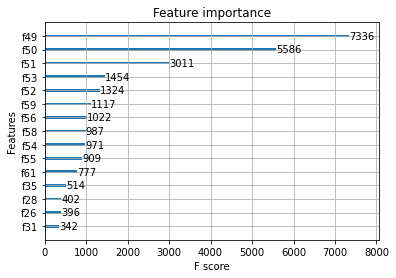

In [ ]:
xgb.plot_importance(modelo_xgb,  max_num_features=15)

In [ ]:
columns =['sum_tfidf_for_dance', 'sum_tfidf_for_pop', 'sum_tfidf_for_r&b',
       'sum_tfidf_for_hip-hop', 'sum_tfidf_for_rap', 'sum_tfidf_for_soul',
       'sum_tfidf_for_rock', 'sum_tfidf_for_blues', 'sum_tfidf_for_folk',
       'sum_tfidf_for_jazz', 'sum_tfidf_for_country',
       'sum_tfidf_for_alternative', 'sum_tfidf_for_children’s music',
       'sum_tfidf_for_indie', 'sum_tfidf_for_electronic',
       'sum_tfidf_for_classical', 'sum_tfidf_for_opera', 'sum_tfidf_for_world',
       'sum_tfidf_for_ska', 'sum_tfidf_for_comedy', 'sum_tfidf_for_reggae',
       'sum_tfidf_for_reggaeton', "sum_tfidf_for_children's music",
       'sum_tfidf_for_soundtrack', 'sum_tfidf_for_anime',
       'sum_tfidf_for_movie'] + \
                  ["length_lyrics", "number_of_lines", "number_of_tokens"] + \
                  ["FW", "JJR", "NN", "NNS", "NNP", "PDT", "PRP", "RB", "RBR",
                   "UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"] + \
                  ["Minus", "Major"] + \
                  ["popularity_by_lang", "loudness_by_lang"] + numerical_features + ordinal_features


In [ ]:
columns[50:60]

['a_popularity',
 'popularity',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness']

Vemos que las features más importantes àra el XGBoost son las features numéricas originales.

## LightGBM

In [ ]:
modelo_gbm = lgb.LGBMClassifier()
modelo_gbm.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
preds = modelo_gbm.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_gbm.classes_), accuracy_score(y_validation, modelo_gbm.predict(X_validation))

(0.3941510257529463, 0.22566564818856394)

 class lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=None, importance_type='split', **kwargs)

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 1, 200, 1),
        'number_of_leaves': hp.quniform("number_of_leaves", 20, 200, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 100),
        'min_split_gain': hp.uniform("min_split_gain", 0, 100),
        'n_estimators': hp.quniform("n_estimators", 3, 350,1),
        'learning_rate': hp.uniform('learning_rate', 0.1,10),
        'reg_alpha': hp.uniform('reg_alpha', 0.1,100),
        'reg_lambda': hp.uniform('reg_lambda', 0.1,100),
        'random_state': 1}

def objective(space):

  evaluation = [( X_train, y_train), ( X_validation, y_validation)]

  classifier = lgb.LGBMClassifier(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), 
                                  min_split_gain = space['min_split_gain'], min_child_weight=space['min_child_weight'],
                                  colsample_bytree=space['colsample_bytree'], learning_rate = space["learning_rate"], 
                                  reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],
                                  random_state=space["random_state"], number_of_leaves = space["number_of_leaves"])
  
  classifier.fit(X_train, y_train, verbose = False,
                 eval_set=evaluation, callbacks=[lgb.early_stopping(15)])

  preds = classifier.predict_proba(X_validation)
  accuracy = top_k_accuracy_score(y_validation, preds, labels = classifier.classes_)
  
  print ("top_k_accuracy_score:", accuracy)
  return {'loss': -accuracy, 'status': STATUS_OK }
  
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
import pickle
pickle.dump(trials, open("myfile.p", "wb"))

trials = pickle.load(open("myfile.p", "rb"))
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=350)

In [ ]:
best_hyperparams_for_lgb = best_hyperparams
best_hyperparams_for_lgb

{'colsample_bytree': 0.576271960803108,
 'learning_rate': 0.12363537982421097,
 'max_depth': 26.0,
 'min_child_weight': 69.66957487276076,
 'min_split_gain': 6.990131692883031,
 'n_estimators': 221.0,
 'number_of_leaves': 97.0,
 'reg_alpha': 14.883554114730167,
 'reg_lambda': 19.837238531460024}

In [ ]:
modelo_mejor_gbm = lgb.LGBMClassifier(n_estimators =int(best_hyperparams_for_lgb['n_estimators']),
                                      max_depth = int(best_hyperparams_for_lgb['max_depth']), 
                                      min_split_gain = best_hyperparams_for_lgb['min_split_gain'], 
                                      min_child_weight=best_hyperparams_for_lgb['min_child_weight'],
                                      colsample_bytree=best_hyperparams_for_lgb['colsample_bytree'], 
                                      learning_rate = best_hyperparams_for_lgb["learning_rate"], 
                                      reg_alpha = best_hyperparams_for_lgb['reg_alpha'], 
                                      reg_lambda = best_hyperparams_for_lgb['reg_lambda'],
                                      number_of_leaves = best_hyperparams_for_lgb["number_of_leaves"])

modelo_mejor_gbm.fit(X_train, y_train, verbose = False)

LGBMClassifier(colsample_bytree=0.576271960803108,
               learning_rate=0.12363537982421097, max_depth=26,
               min_child_weight=69.66957487276076,
               min_split_gain=6.990131692883031, n_estimators=221,
               number_of_leaves=97.0, reg_alpha=14.883554114730167,
               reg_lambda=19.837238531460024)

In [ ]:
preds = modelo_mejor_gbm.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_mejor_gbm.classes_), accuracy_score(y_validation, modelo_mejor_gbm.predict(X_validation))

(0.5229157573112178, 0.3304233958969882)

Como el mejor de los dos es el LGBM en base al score en validation, medimos la performance en test con él:

In [ ]:
X_test = full_processor.transform(eliminate_genres_without_enough_observations(df_music_test))
y_test = label_encoder.transform(eliminate_genres_without_enough_observations(df_music_test).genre)

In [ ]:
test_preds = modelo_mejor_gbm.predict_proba(X_test)
top_k_accuracy_score(y_test, test_preds, labels = modelo_mejor_gbm.classes_)

0.5025623505295524

In [ ]:
pd.DataFrame(test_preds).to_csv("test_results.csv")

## Ensemble de los modelos por averaging

In [ ]:
class AveragingEnsembleModel():
  def __init__(self, models):
    self.n_models = len(models)
    self.models = models
  
  def predict_proba(self, X):
    predictions = [model.predict_proba(X) for model in self.models]
    return np.sum(predictions, axis = 0)/self.n_models

  def predict(self, X):
    return np.argmax(self.predict_proba(X), axis = 1)

In [ ]:
ensemble = AveragingEnsembleModel(models = [modelo_xgb, modelo_mejor_gbm])
ensemble.predict(X_validation)

array([ 0,  3,  3, ...,  7, 15,  1])

In [ ]:
preds = ensemble.predict_proba(X_validation)
top_k_accuracy_score(y_validation, preds, labels = modelo_mejor_gbm.classes_)

0.5325185508511567

Vemos que el ensemble tiene mejor validation top_2_accuracy que ambos modelos por sí solos.

In [ ]:
test_preds = ensemble.predict_proba(X_test)
top_k_accuracy_score(y_test, test_preds, labels = modelo_mejor_gbm.classes_)

0.5083703450632047

Notamos que también mejora ligeramente la de test!